## <font color="darkblue"> This Project: Fourier Analysis Via Linear Regression </font>

### <font color="darkblue"> Background Material </font>

Suppose that we have a *time series*: at an ordered set of times $t_k$, $k=1,\ldots,N$ such that $0\lt t_1\lt t_2\lt\ldots\lt t_N\lt T$ we have acquired real scalar-valued data $y_k$, $k=1,\ldots,N$.  The $y_k$ could represent X-ray flux observations from a pulsar, or stellar brightness observations from a variable source, or gravitational wave strain observations, or solar activity measurements, for example.  This is a very common data type in astronomy and in other sciences.

Assuming heteroscedastic normally-distributed experimental noise (i.e. different variances $\sigma_k^2$), the statistical model for the data is
$$
Y_k=f(t_k)+\epsilon_k \quad;\quad \epsilon_k\sim\mathcal{N}(0,\sigma_k^2),
$$
for some model function $f(t)$. The data $y_k$ are samples from the RVs $Y_k$.

A very common model for $f(t)$ is a *Fourier Series*:
$$
f(t)=a_0 + \sum_{k=1}^\infty \left[
a_k^{(c)}\cos\left(\frac{2\pi k}{T}t\right) + a_k^{(s)}\sin\left(\frac{2\pi k}{T}t\right)
\right].
$$

This type of series representation is a powerful alternative to Taylor series.  It turns out that any smooth integral function on the domain $(0,T)$ can be represented uniquely in this way.  The representation is interesting because it allows us to represent *multiple superposed periodicities*: the terms $\cos\left(\frac{2\pi k}{T}t\right)$ and $\sin\left(\frac{2\pi k}{T}t\right)$ are periodic with period $T/k$.  

Should the coefficients $a_k^{(s)},a_k^{(c)}$ due to one value of $k$ dominate the others in the series, it would be evidence of a periodic effect in the physics responsible for the observations (for example, an exoplanet orbital period).

Typically, one cares principally about the *power spectrum* $s_k$ of the series, defined as
$$
s_0 \equiv a_0^2 \quad;\quad s_k\equiv a_k^{(c)\,2} + a_k^{(s)\,2},\, k>0.
$$

This is the influence of the periodicity $T/k$ on $f(t)$, and is referred to as the *power* in mode $k$.

Extracting power spectra from time series is a major enterprise of statistical analysis. If (when) you encounter the terms *discrete Fourier Transform* (DFT) or *Fast Fourier Transform* (FFT), this is the subject concerned. Fourier analysis is a very large, dense subject, whose details will not detain us here.

In practice, one never extracts an infinite number of $s_k$, of course. Instead, one approximates $f(t)$ by truncating the series to a finite number $B$ of modes, i.e.
$$
f(t)\approx a_0 + \sum_{k=1}^B \left[
a_k^{(c)}\cos\left(\frac{2\pi k}{T}t\right) + a_k^{(s)}\sin\left(\frac{2\pi k}{T}t\right)
\right].
$$

With this approximation, the statistical model becomes
$$
Y_k = a_0 + \sum_{k=1}^B \left[
a_k^{(c)}\cos\left(\frac{2\pi k}{T}t_k\right) + a_k^{(s)}\sin\left(\frac{2\pi k}{T}t_k\right)
\right]+\epsilon_k \quad;\quad \epsilon_k\sim\mathcal{N}(0,\sigma_k^2).
$$

**It will surely not have escaped your attention that *this is a linear model* in the Fourier coefficients $a_0, a_k^{(c)}, a_k^{(s)}$.**   The only difference with the polynomial models discussed in class and in the homework is that the basis of functions are the periodic functions $\cos\left(\frac{2\pi k}{T}t\right), \sin\left(\frac{2\pi k}{T}t\right)$, instead of the monomials ${x_l}^k$.

### <font color="darkblue"> Project Prompts </font>

You will receive your own customized dataset.  It will look like some version of this:

<center>
<img width=1000 src="https://web.cels.anl.gov/~cgraziani/ASTRO21000/Fourier_data.png"></img>
</center>

Assume that your Fourier series should be truncated at $B=20$.  

1. Plot your own data.  Always do that first.

2. Obviously, you need to perform inference on the linear coefficients $\mathbf{a}$. Can you see how to adapt the polynomial regression method to this case? The target should be the mean and covariance of the $\mathbf{a}$.

3. Can your model predict the time-series at times not actually observed?
    * Between actual observations? 
    * Outside the observation window?
    * Can it exhibit the uncertainty in the prediction?

5. What can you say about the spectrum, $s_k$?  It's quadratic in the $\mathbf{a}$, so getting its statistical distribution at each mode $k$ in closed form is non-trivial.  
    * Could a posterior sampling approach work here?
    * Would you expect to get good credible regions for the $s_k$ using a $\pm\sigma$ type of approach? What might be an alternative approach? Could quantiles be better?
    * Is there any gain in understanding of the spectrum if you plot it in log-linear, or log-log coordinates?
    * Is there any "special" frequency mode where the spectrum is significantly higher than it is at nearby modes?
    * Are the $s_k$ at different $k$ correlated or uncorrelated? Can you think of some way to display their correlations?

6. You could try experimenting with values of $B$ that are larger, or smaller than 20, to see what happens. 

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
# Data loading
data = np.loadtxt('time_series.txt')
t = data[:, 0]
signal = data[:, 1]
sigma = data[:, 2]

### Plot of Data

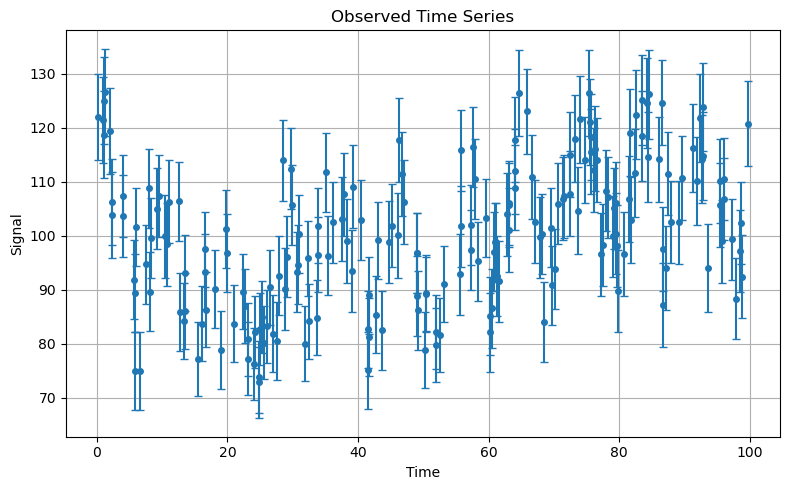

In [4]:
# Plot
plt.figure(figsize=(8,5))
plt.errorbar(t, signal, yerr=sigma, fmt='o', markersize=4, capsize=3)

plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Observed Time Series')
plt.grid(True)
plt.tight_layout()
plt.show()

### Fourier Regression

The Fourier design matrix is $\mathbf{Phi}$ containing $N$ (sample size) rows and $2B+1$ columns. This constructs the linear regression basis, and we proceed with weighted least squares. That is $$\mathbf{W}=\text{diag} \left( \frac{1}{\sigma_1&2}, \dots, \frac{1}{\sigma_N^2} \right)$$ is the weight matrix (since the noise is heteroscedastic Gaussian, and the likelihoods are weighted by $\frac{1}{\sigma_k^2}$).

In [5]:
y = signal
yerr = sigma

B = 20
T = 100.0

# This is where the fourier regression block begins technically, 
# this first half (constructing the Fourier basis up to mode B with sines/cosines is fourier regression really)

# Design matrix (sine and cosine pairs, w/ intercept term)
N = len(t)
Phi = np.zeros((N, 2*B + 1))
Phi[:,0] = 1  # intercept, mean level
for k in range(1, B+1):
    Phi[:, 2*k-1] = np.cos(2 * np.pi * k * t / T)
    Phi[:, 2*k]   = np.sin(2 * np.pi * k * t / T)

# Weighted least squares fit
W = np.diag(1/yerr**2)
A = Phi.T @ W @ Phi
b = Phi.T @ W @ y
a_hat = np.linalg.solve(A, b)
cov_a = np.linalg.inv(A)   # Covariance of coefficients


In [ ]:
# Predict at fine grid
t_dense = np.linspace(0, 100, 1000)
Phi_dense = np.zeros((len(t_dense), 2*B+1))
Phi_dense[:,0] = 1
for k in range(1, B+1):
    Phi_dense[:, 2*k-1] = np.cos(2 * np.pi * k * t_dense / T)
    Phi_dense[:, 2*k]   = np.sin(2 * np.pi * k * t_dense / T)
    
y_pred = Phi_dense @ a_hat
y_pred_std = np.sqrt(np.sum(Phi_dense @ cov_a * Phi_dense, axis=1))

# Plot it!
plt.figure(figsize=(8,4))
plt.errorbar(t, y, yerr=yerr, fmt='o', capsize=2, label='Data')
plt.plot(t_dense, y_pred, label='Model Prediction')
plt.fill_between(t_dense, y_pred-1.96*y_pred_std, y_pred+1.96*y_pred_std, color='orange', alpha=0.2, label='95% Uncertainty')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Weighted LS Fourier Fit, B=20')
plt.tight_layout()
plt.show()

### Predictive Distribution

Let's place a prior on the Fourier coefficients $\mathbb{a}$. Choosing a Gaussian prior, we have $$\mathbb{a} \sim \mathcal{N}(0, \Sigma_0).$$ With Gaussian observational noise (heteroscedastic but known $\sigma_k$), he posterior over $\mathbb{a}$ is Gaussian and the predictive distribution for $f(t)$ is Gaussian also: 
$$\mathbb{a} \mid y \sim \mathcal{N} (\mu_{post}, \Sigma_{post})$$
where $\mu_{post} = \Sigma_{post} X^\top Wy$ and $\Sigma_{post}=(X^\top WX + \Sigma_0^{-1})^{-1}$. It follows that $$f(t_*) \mid y \sim \mathcal{N}(X_* \mu_{post}, X_* \Sigma_{post} X_*^\top).$$ 

In [8]:
B = 20   # number of Fourier modes

# Observation window length
T = t.max() - t.min()

def build_design_matrix(t, B, T):
    N = len(t)
    cols = [np.ones(N)]  # a0 term
    for k in range(1, B+1):
        w = 2*np.pi*k/T
        cols.append(np.cos(w*t))
        cols.append(np.sin(w*t))
    X = np.column_stack(cols)
    return X

X = build_design_matrix(t, B, T)
p = X.shape[1]

# Prior
tau2 = 1e4 # I put this here arbitrarily
Sigma0 = np.eye(p) * tau2   # prior covariance
invSigma0 = np.eye(p) / tau2  # prior precision

# Observational precision matrix W
W = W = np.diag(1.0 / (sigma**2))

# Posteriors
XTW_X = X.T @ W @ X      # shape (p,p)
XTW_y = X.T @ W @ signal # shape (p,)

# Posterior precision and covariance
post_precision = XTW_X + invSigma0
Sigma_post = np.linalg.inv(post_precision)
mu_post = Sigma_post @ XTW_y

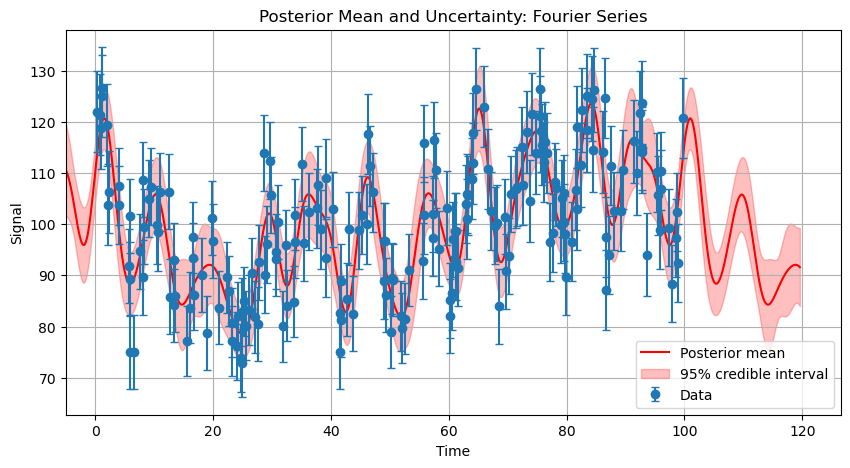

In [9]:
# Predictive mean
tpred = np.linspace(t.min() - 0.2*(t.max()-t.min()),
                    t.max() + 0.2*(t.max()-t.min()), 2000)

Xpred = build_design_matrix(tpred, B, T)
fmean = Xpred @ mu_post
fvar = np.sum((Xpred @ Sigma_post) * Xpred, axis=1)   # diag(X Sigma X^T)
fstd = np.sqrt(fvar)

cred_level = 0.95
z = norm.ppf(0.5 + cred_level/2) # two sided z score

# Plot posterior mean
plt.figure(figsize=(10,5))
plt.plot(tpred, fmean, 'r-', label='Posterior mean')
plt.fill_between(tpred, fmean - 1.96*fstd, fmean + 1.96*fstd, color='r', alpha=0.25,
                 label='95% credible interval')
plt.errorbar(t, signal, yerr=sigma, fmt='o', capsize=3, label='Data')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Posterior Mean and Uncertainty: Fourier Series')
plt.xlim(-5)
plt.legend(); plt.grid(True); plt.show()

In [10]:
# just for visualization ;)

coefs = pd.DataFrame({
    'index': np.arange(p),
    'mean': mu_post,
    'std': np.sqrt(np.diag(Sigma_post))
})
print(coefs.head(10))  # First 10 coefficients

# Uncertainty outside of the observed window
print("Uncertainty at tpred edges:", fstd[0], fstd[-1])

   index        mean       std
0      0  100.078383  0.558085
1      1    3.753075  0.813201
2      2   -9.212487  0.762138
3      3    0.735275  0.775336
4      4   -3.436374  0.805808
5      5    2.890136  0.787772
6      6    1.424571  0.790797
7      7   -1.892834  0.776268
8      8    0.178365  0.804022
9      9    0.120630  0.779175
Uncertainty at tpred edges: 2.9050914140034956 3.8866330465378036


### Power Spectrum $s_k$

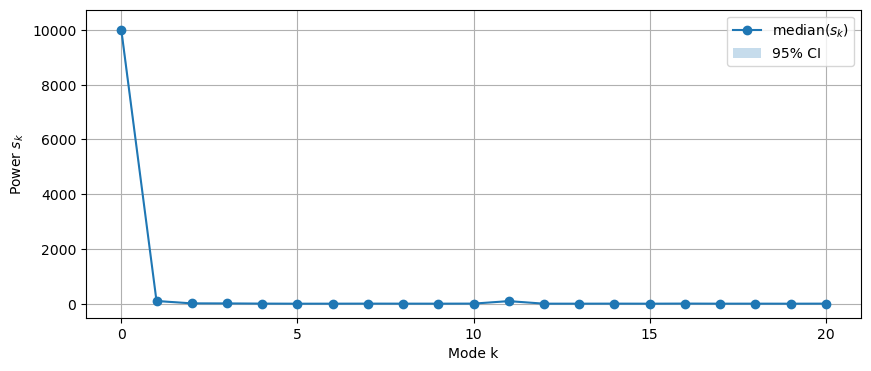

In [11]:
# Posterior samples
nsamples = 5000
samples = np.random.multivariate_normal(mean=mu_post, cov=Sigma_post, size=nsamples)

# Compute s_k for each sample
s_samples = np.zeros((nsamples, B+1))
s_samples[:,0] = samples[:,0]**2
idx = 1
for k in range(1, B+1):
    ac = samples[:, idx]
    as_ = samples[:, idx+1]
    s_samples[:, k] = ac**2 + as_**2
    idx += 2

# summary quantiles for spectrum
s_med = np.median(s_samples, axis=0)
s_lo = np.percentile(s_samples, 2.5, axis=0)
s_hi = np.percentile(s_samples, 97.5, axis=0)

modes = np.arange(B+1)
plt.figure(figsize=(10,4))
plt.plot(modes, s_med, '-o', label='median($s_k$)')
plt.fill_between(modes, s_lo, s_hi, alpha=0.25, label='95% CI')
plt.xlabel('Mode k')
plt.ylabel('Power $s_k$')
plt.xticks([0,5,10,15,20])
plt.legend(); plt.grid(True); plt.show()

### Same plot but in log scale

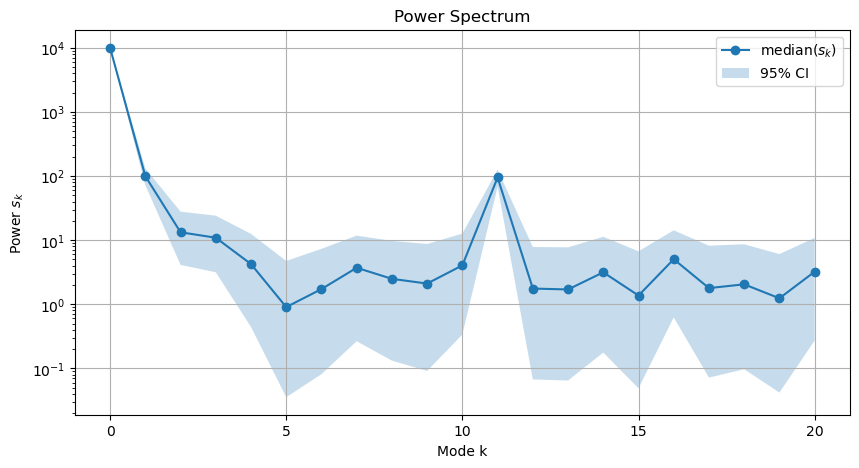

In [12]:
plt.figure(figsize=(10,5))
plt.semilogy(modes, s_med, '-o', label='median($s_k$)')
plt.fill_between(modes, s_lo, s_hi, alpha=0.25, label='95% CI')
plt.xlabel('Mode k') # frequency index
plt.ylabel('Power $s_k$')
plt.xticks([0,5,10,15,20])
plt.title('Power Spectrum')
plt.legend(); plt.grid(True); plt.show()

### Posterior Sample Curves

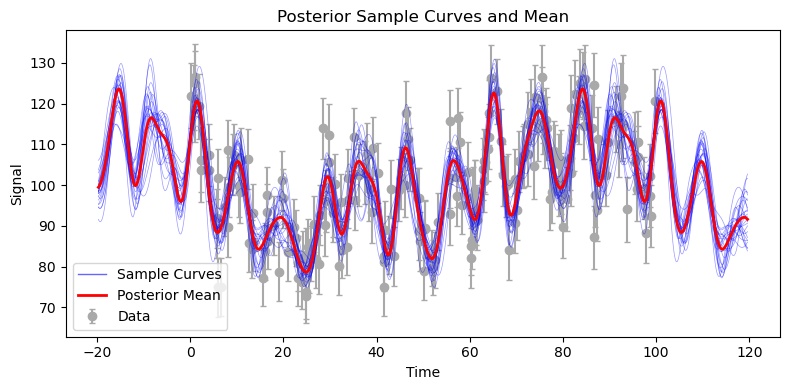

In [13]:
# Sample predictions for posterior model/variability of the model
n_show = 25
curves = Xpred @ samples[:n_show].T

plt.figure(figsize=(8,4))
for c in range(n_show):
    plt.plot(tpred, curves[:, c], color='blue', lw=0.5, alpha=0.4, zorder=3)

sample_handle = plt.Line2D([], [], color='blue', lw=1, alpha=0.6, label='Sample Curves')
plt.gca().add_line(sample_handle)

plt.plot(tpred, fmean, 'r-', lw=2, label='Posterior Mean', zorder=4)
plt.errorbar(t, signal, yerr=sigma, fmt='o', capsize=2,
             color='darkgrey', label='Data', zorder=1)

plt.legend()
plt.title('Posterior Sample Curves and Mean')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.tight_layout()
plt.show()

**BIC**

In [ ]:
#Observation window length
T = t.max() - t.min()
N = len(t) #Total number of data points

def calculate_bic(ssr, N, k):
    # The term N * np.log(ssr / N) is equivalent to N * np.log(sigma_hat^2)
    return N * np.log(ssr / N) + k * np.log(N)

def calculate_ssr_from_fourier_fit(t, signal, sigma, B):
    """
    Fits the Fourier series model for a given B, and calculates SSR.
    We are using the provided Bayesian framework (mu_post is the mean fit).
    """
    T = t.max() - t.min()
    X = build_design_matrix(t, B, T)
    p = X.shape[1] # Number of parameters for mode B (2B + 1)

    tau2 = 1e4
    invSigma0 = np.eye(p) / tau2

    #Observational precision matrix W
    W = np.diag(1.0 / (sigma**2))

    #Posteriors
    XTW_X = X.T @ W @ X
    XTW_y = X.T @ W @ signal

    # P\osterior precision and covariance
    post_precision = XTW_X + invSigma0
   
    Sigma_post = np.linalg.inv(post_precision) 
    mu_post = Sigma_post @ XTW_y

    #Model prediction at the data points
    model_mean = X @ mu_post

    #Sum of Squared Residuals (SSR)
    residuals = signal - model_mean
    ssr = np.sum(residuals**2)

    return ssr, p


In [ ]:
def find_best_truncation_bic_multiple(t, signal, sigma, max_modes=20, bic_tolerance=2.0):
    """
    Finds the best Fourier modes (B) using BIC, and returns all modes 
    whose BIC is within a specified tolerance of the minimum BIC.
    
    bic_tolerance: The maximum BIC difference from the minimum accepted 
                   for a mode to be considered "good." (e.g., 2.0 or 6.0)
    """
    N = len(t)
    results = {}  # Dictionary to store {B: BIC} for all modes

    # --- 1. Calculate BIC for B=0 (DC term only) ---
    mean_signal = np.mean(signal)
    ssr_0 = np.sum((signal - mean_signal)**2)
    k_0 = 1 
    bic_0 = calculate_bic(ssr_0, N, k_0)
    results[0] = bic_0
    
    # --- 2. Calculate BICs for B=1 up to max_modes ---
    modes = list(range(1, max_modes + 1))
    
    print(f"Testing modes B=0 to B={max_modes}...")
    
    for B in modes:
        try:
            # Get SSR and number of parameters (k = 2B + 1)
            ssr, k = calculate_ssr_from_fourier_fit(t, signal, sigma, B) 
            bic = calculate_bic(ssr, N, k)
            results[B] = bic
            print(f"Modes (B) {B}: BIC = {bic:.2f}")
        except np.linalg.LinAlgError:
            print(f"Warning: Singular matrix encountered at B={B}. Stopping mode calculation.")
            break

    # --- 3. Determine the Absolute Best Mode ---
    if not results:
        print("No successful BIC calculations.")
        return [], 0, {}

    # Find the B with the overall minimum BIC
    best_mode = min(results, key=results.get)
    min_bic = results[best_mode]

    # --- 4. Select Modes within the Tolerance ---
    # This selects all B whose BIC is less than or equal to (min_bic + tolerance)
    good_modes = [
        B for B, bic in results.items() 
        if bic <= (min_bic + bic_tolerance)
    ]
    
    # Sort the good modes and their corresponding BICs
    good_modes.sort()
    good_bics = {B: results[B] for B in good_modes}
    
    print("-" * 40)
    print(f"Absolute Best Mode: B={best_mode} (BIC: {min_bic:.2f})")
    print(f"Good Modes (within BIC + {bic_tolerance:.1f}): {good_modes}")
    print("-" * 40)

    # Return the list of good modes and the full results dictionary
    return good_modes, best_mode, results

In [46]:
good_modes, overall_best, full_results = find_best_truncation_bic_multiple(t, signal, sigma, max_modes=50, bic_tolerance=25.0)

Testing modes B=0 to B=50...
Modes (B) 1: BIC = 975.07
Modes (B) 2: BIC = 976.43
Modes (B) 3: BIC = 975.64
Modes (B) 4: BIC = 984.75
Modes (B) 5: BIC = 994.70
Modes (B) 6: BIC = 1003.42
Modes (B) 7: BIC = 1008.77
Modes (B) 8: BIC = 1017.93
Modes (B) 9: BIC = 1027.28
Modes (B) 10: BIC = 1034.29
Modes (B) 11: BIC = 910.47
Modes (B) 12: BIC = 919.83
Modes (B) 13: BIC = 927.26
Modes (B) 14: BIC = 933.85
Modes (B) 15: BIC = 942.73
Modes (B) 16: BIC = 945.24
Modes (B) 17: BIC = 952.94
Modes (B) 18: BIC = 961.45
Modes (B) 19: BIC = 971.28
Modes (B) 20: BIC = 976.61
Modes (B) 21: BIC = 985.90
Modes (B) 22: BIC = 995.54
Modes (B) 23: BIC = 998.04
Modes (B) 24: BIC = 997.83
Modes (B) 25: BIC = 1005.08
Modes (B) 26: BIC = 1009.61
Modes (B) 27: BIC = 1017.96
Modes (B) 28: BIC = 1018.75
Modes (B) 29: BIC = 1026.05
Modes (B) 30: BIC = 1033.99
Modes (B) 31: BIC = 1044.14
Modes (B) 32: BIC = 1054.00
Modes (B) 33: BIC = 1062.56
Modes (B) 34: BIC = 1070.37
Modes (B) 35: BIC = 1079.41
Modes (B) 36: BIC =

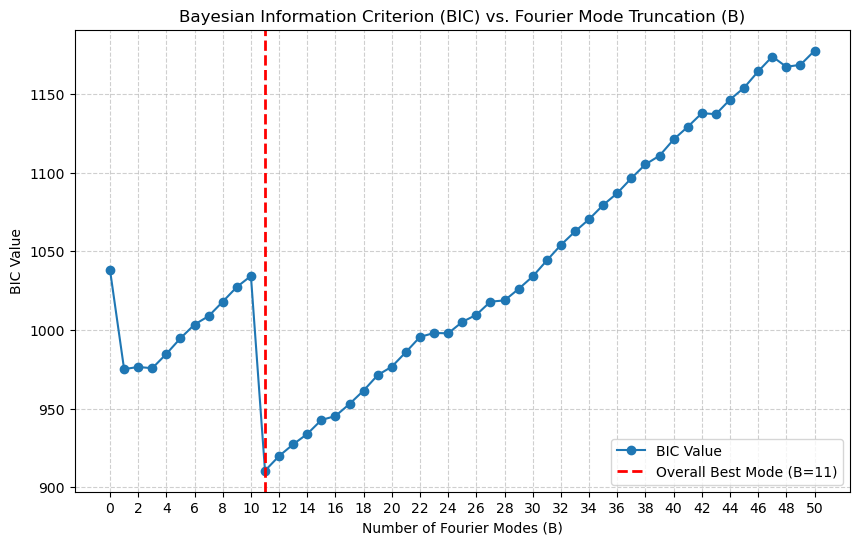

In [41]:
sorted_items = sorted(full_results.items())
modes_to_plot = [item[0] for item in sorted_items]
bics = [item[1] for item in sorted_items]        

min_bic_value = full_results[overall_best]

plt.figure(figsize=(10, 6))

# Plot the full BIC curve
plt.plot(modes_to_plot, bics, 'o-', color='tab:blue', label='BIC Value')

plt.axvline(overall_best, color='red', linestyle='--', linewidth=2, label=f'Overall Best Mode (B={overall_best})')

good_modes_set = set(good_modes)
for mode in good_modes:
    if mode != overall_best:
        plt.axvline(
            mode, 
            color='green', 
            linestyle=':', 
            alpha=0.7, 
        )


plt.title('Bayesian Information Criterion (BIC) vs. Fourier Mode Truncation (B)')
plt.xlabel('Number of Fourier Modes (B)')
plt.ylabel(r'BIC Value') 
plt.xticks(np.arange(0, np.max(modes_to_plot) + 1, 2))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()